# Painter GAN

In this project, it is desired that we develop a pair of discriminator and generator which learn from each other, and our final goal is to have a generator that can generate images that are comparable to those of Monet.

Let's start by obtaining the image datasets.

In [3]:
import tensorflow as tf
#/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec
#/kaggle/input/gan-getting-started/photo_jpg/000910d219.jpg
samples = tf.data.TFRecordDataset('/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec')
for s in samples.take(1):
    ex=tf.train.Example()
    ex.ParseFromString(s.numpy())
    print(list(ex.features.feature.keys()))

['target', 'image', 'image_name']


Now we know that there are three columns in each of the objects stocked in those tfrec files. We need to check one example.

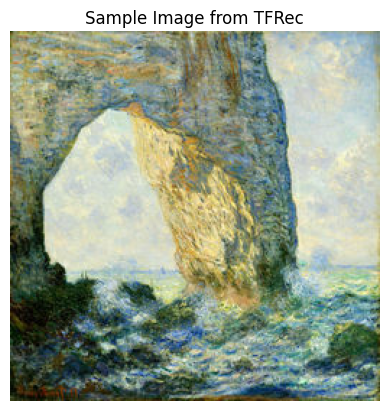

In [4]:
import matplotlib.pyplot as plt

for s in samples.take(1):
    parsed=tf.io.parse_single_example(s, {
        'image':tf.io.FixedLenFeature([],tf.string),
        'image_name':tf.io.FixedLenFeature([],tf.string),
        'target':tf.io.FixedLenFeature([],tf.string)
    })
    img=tf.io.decode_jpeg(parsed['image'],channels=3)
    img2=tf.image.convert_image_dtype(img,tf.float32)
    name=parsed['image_name']
    target=parsed['target']
    
plt.figure()
plt.imshow(img2.numpy())
plt.title('Sample Image from TFRec')
plt.axis('off')
plt.show()

In [5]:
print(target,name)

tf.Tensor(b'monet', shape=(), dtype=string) tf.Tensor(b'25c9904782', shape=(), dtype=string)


We can do it better by using .map in Python and apply the function to several samples.

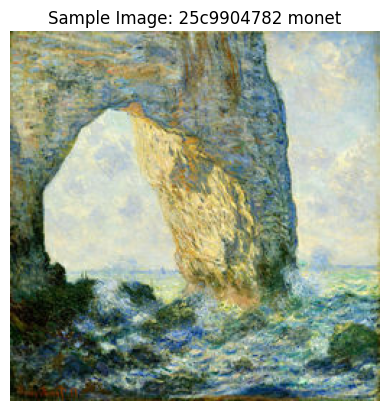

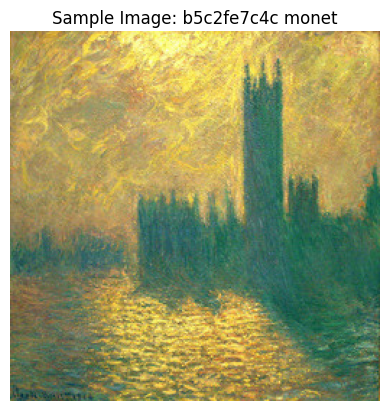

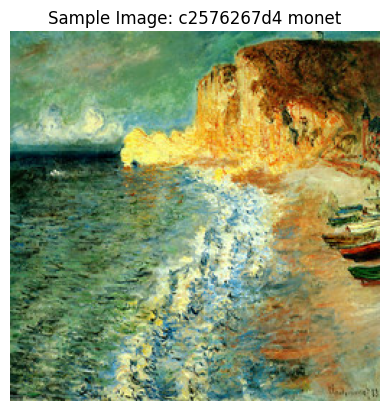

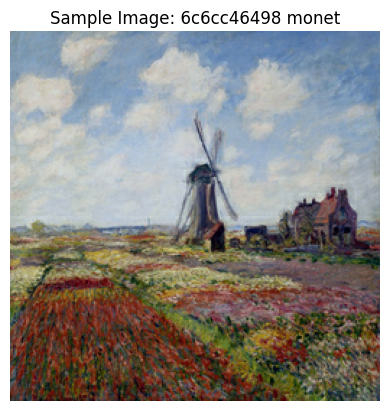

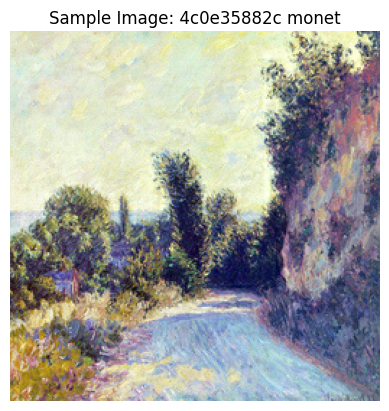

In [6]:
def parseGetImage(s):
    parsed=tf.io.parse_single_example(s, {
        'image':tf.io.FixedLenFeature([],tf.string),
        'image_name':tf.io.FixedLenFeature([],tf.string),
        'target':tf.io.FixedLenFeature([],tf.string)
    })
    img=tf.io.decode_jpeg(parsed['image'],channels=3)
    img2=tf.image.convert_image_dtype(img,tf.float32)
    name=parsed['image_name']
    target=parsed['target']
    return (img2,name,target)

parsedSamples=samples.take(5).map(parseGetImage)

for img,name,tgt in parsedSamples:
    plt.figure()
    plt.imshow(img.numpy())
    plt.title('Sample Image: '+name.numpy().decode('utf-8')+' '+tgt.numpy().decode('utf-8'))
    plt.axis('off')
    plt.show()

We will check the other folder as well.

In [7]:
"""samples2 = tf.data.TFRecordDataset('/kaggle/input/gan-getting-started/photo_tfrec/photo00-352.tfrec')

parsedSamples2=samples2.take(5).map(parseGetImage)

for img2,name2,tgt2 in parsedSamples2:
    plt.figure()
    plt.imshow(img2.numpy())
    plt.title('Sample Image: '+name2.numpy().decode('utf-8')+' '+tgt2.numpy().decode('utf-8'))
    plt.axis('off')
    plt.show()
"""

"samples2 = tf.data.TFRecordDataset('/kaggle/input/gan-getting-started/photo_tfrec/photo00-352.tfrec')\n\nparsedSamples2=samples2.take(5).map(parseGetImage)\n\nfor img2,name2,tgt2 in parsedSamples2:\n    plt.figure()\n    plt.imshow(img2.numpy())\n    plt.title('Sample Image: '+name2.numpy().decode('utf-8')+' '+tgt2.numpy().decode('utf-8'))\n    plt.axis('off')\n    plt.show()\n"

Beautiful.

It seems that target is just the name of the author, and "monet" is one possible value. "image_name" is just the file name that is a meaningless code for us.

In [8]:
import numpy as np

print(img2.shape)
print(type(img2))
print(np.array(img2).flatten().max(),np.array(img2).flatten().min())
print(np.array(img2).flatten())

(256, 256, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
1.0 0.0
[0.15294118 0.22352943 0.         ... 0.36862746 0.37254903 0.06666667]


We get some important information about the images. They have 3 channels and they are 256x256 in size. The values are from 0 to 1. We need to process the images before feeding them to the discriminator and the generator.

In [9]:
def parseImg(s):
    parsed=tf.io.parse_single_example(s, {
        'image':tf.io.FixedLenFeature([],tf.string),
        'image_name':tf.io.FixedLenFeature([],tf.string),
        'target':tf.io.FixedLenFeature([],tf.string)
    })
    img=tf.io.decode_jpeg(parsed['image'],channels=3)
    img2=tf.image.convert_image_dtype(img,tf.float32)
    #img3=(img-0.5)*2 # to convert the images to [-1,1]
    return img2 #3

#tf.io.gfile.glob(*) to get all of them
samples = tf.data.TFRecordDataset('/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec')
parsed=samples.map(parseGetImage)

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.15294118, 0.22352943, 0.        ],
        [0.24705884, 0.3137255 , 0.09803922],
        [0.43137258, 0.49803925, 0.32156864],
        ...,
        [0.47058827, 0.54509807, 0.4666667 ],
        [0.427451  , 0.50980395, 0.43529415],
        [0.45882356, 0.54901963, 0.47058827]],

       [[0.36078432, 0.3019608 , 0.07058824],
        [0.41176474, 0.37647063, 0.16078432],
        [0.5176471 , 0.5019608 , 0.31764707],
        ...,
        [0.49411768, 0.5686275 , 0.54509807],
        [0.45882356, 0.5411765 , 0.5137255 ],
        [0.48627454, 0.5764706 , 0.54509807]],

       [[0.4431373 , 0.38431376, 0.12941177],
        [0.49803925, 0.45098042, 0.21568629],
        [0.5568628 , 0.5294118 , 0.31764707],
        ...,
        [0.5019608 , 0.5921569 , 0.6156863 ],
        [0.47058827, 0.5647059 , 0.5803922 ],
        [0.4901961 , 0.58431375, 0.6       ]],

       ...,

       [[0.30980393, 0.3529412 , 0.21960786],
        [0.2

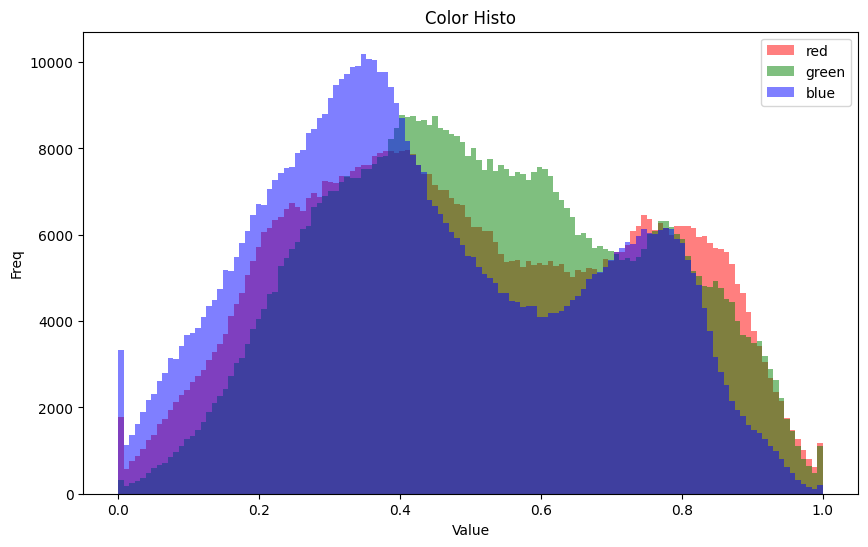

In [10]:
for data in parsed.take(1):
    print(data)

cs=["red","green","blue"]
rs=[]
gs=[]
bs=[]
rgbs=[rs,gs,bs]

for i,img in enumerate(parsed.take(10)):
    img2=img[0].numpy()
    for j in range(3):
        rgbs[j].extend(img2[:,:,j].ravel())

plt.figure(figsize=(10,6))

for j in range(3):
    plt.hist(rgbs[j],bins=128,color=cs[j],alpha=0.5,label=cs[j])

plt.title("Color Histo")
plt.xlabel("Value")
plt.ylabel("Freq")
plt.legend()
    

As you can see, in our 10 samples, the rgb colors are almost normally distributed, with very little differences among them. Now that we have the data, we can start building our generator.

To design the generator, we make it possible to input the number of latent parameters, which determines the number of random values to be generated in order to generate each image. Since the objective is to make an image of a shape of 256x256x3, we want to convert the random values into a shape that can be further expanded to the final shape, and we choose 16x16x256, where 256 is the number of filters in the dense layer and also the number of outputs coming out the dense layer to the next layer,

Noticing that, in order a 16x16 images become a 256x256 image, we need to multiple both horizontal and vertical dimensions by 2 to the power of 4. In order to do that, we can use Conv2DTranspose with a certain stride to expand the intermediate images. For example, we can use 4 Conv2DTranspose with the same stride (2,2) to apply this multiplication of dimensions to get a final image of 256x256.

On the other hand, the number of filters decides the output size coming out form the layer, which means that the last layer must have an output size of 3 to output 3 channels. As for the number of filters in the middle, to cater to the machine learning pattern, we make them decreasing and powers of 2.

Last but not least, I use "reLu" as the activation function for all the Conv2DTranspose layers and sigmoid for the last layer to scale the outpout to (0,1). I added also some normalization layers to maintain the stability of the model.

In [11]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Reshape,Conv2DTranspose,BatchNormalization,Input

def buildGen(latent):
    model=tf.keras.Sequential()
    model.add(Input(shape=(latent,)))
    model.add(Dense(16*16*256))
    model.add(Reshape((16,16,256)))
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64,(4,4),strides=(2,2),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32,(4,4),strides=(2,2),padding='same',activation='relu'))
    model.add(Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid'))
    model.summary()
    return model

Then, we can build our discriminator. This is the opposte to what the generator wants to achieve, which is that it wants to convert an image of size of 256x256x3 to a single number. For simplicity, I decided to use 2 Conv2D layers with respectively 64 and 128 filters, since I want to capture some features and then let the machine learn deeper features based on simpler features, which corresponds to how machines learn about image features. I use strides to decrease the size of parameters to avoid overfit and reduce the workload for the machine learning.

I use leaky reLu as the activation function for the middle layers. Instead of making the negative inputs become 0, I apply a small slope to the negative inputs, differently from the reLu activation. This activation function should be able to make the machine learn about non-linear featuers in the graphs.

It is crucial to use sigmoid as an activation function at the last layer, which should only have 1 filter to output only one value between 0 and 1, because the discriminator is a machine for binary classification.



In [12]:
from tensorflow.keras.layers import Conv2D,LeakyReLU,Flatten

def buildDis():
    model=tf.keras.Sequential()
    model.add(Input(shape=(256,256,3)))
    model.add(Conv2D(64,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

We also need to create instances of generator and disciminator.

In [13]:
optimizerGen=tf.keras.optimizers.Adam(0.001,beta_1=0.5)
optimizerDis=tf.keras.optimizers.Adam(0.001,beta_1=0.5)

lossFunc=tf.keras.losses.BinaryCrossentropy()


latentDim=10
gen=buildGen(latentDim)
dis=buildDis()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 65536)          │       720,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,555 (5.38 MB)

 Trainable params: 1,411,171 (5.38 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,625 (2.51 MB)

 Trainable params: 658,625 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In our training process, we will use MiFiD (Memorization-informed FID) to evaluate the diversity and quality of the generator. The formula is given in the competition. As is also shown in the code, MiFiD is just the ratio of fid over imaginary distance when the latter is within a threshold, and is equal to fid whe nthe imaginary distance is bigger than a threshold.

To calculate fid and the imaginary distance, we need to first find out the feature matrices with the help of the inception model. With the feature matrices for both fake images and real images, we can further calculate their respective means per feature and covariance among features. Just to mention, the mean matrices should have as many elements as the features and the covariance matrix should have as many rows and as many columns as the features. In addition, we can calculate the covariance matrix between real images and fake images by multiplying the real images' feature matrix by the fake images' feature matrix. Since some imaginary values might be produced, we also perform a procedure to convert complex numbers to real numbers.

Once we have all of the above, we can calculate fid by adding the sum of square differences for all features to trace of the matrix obtained by summing up the two covariance matrices substrated by two times the covariance between real image features and fake image features.

To obtain the imaginary distance, first we need to find the mininum cosine similarity for each feature and then find the mean of all the minimum cosine similarities.

In [14]:
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics.pairwise import cosine_similarity

inceptionModel = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

# F - fake, generator, R - real, discriminator
def getFeatures(imgs):
    features=[]
    for img in imgs:
        img=tf.image.resize(img,(299,299)) # size=(299,299,3)
        # rescale to [-1,1] and give an extra dimension for batch
        f=inceptionModel.predict(tf.expand_dims(img*2-1,axis=0), verbose=0) 
        # size=(# of batches,299,299,3)
        features.append(f)
    return np.array(features) # size=(# of batches,1,# of features)

def replaceNegEigenvaluesSqrt(mat,epsilon=10**-6):
    eigvals,eigvecs=tf.linalg.eigh(mat)
    eigvals=tf.maximum(eigvals,epsilon)
    return tf.matmul(tf.matmul(eigvecs,tf.linalg.diag(tf.sqrt(eigvals))),eigvecs,transpose_b=True)
    
def mifid(rs,fs,thres=0.2):
    reals0=getFeatures(rs)
    fakes0=getFeatures(fs) # size=(# of batches,1,# of features)
    
    # np.cov below takes only 1-D or 2-D matrices
    # we need to flatten the features because there are 3 dimensions with the middle dim=1 (useless)
    reals = reals0.reshape(reals0.shape[0], -1) 
    fakes = fakes0.reshape(fakes0.shape[0], -1) 
    # size=(# of batches,# of features)
    #print(reals.shape,fakes.shape,reals0.shape,fakes0.shape)
    
    meanR=tf.convert_to_tensor(reals.mean(axis=0), dtype=tf.float32) # size = # of features
    varR=tf.convert_to_tensor(np.cov(reals,rowvar=False), dtype=tf.float32) # size = # of features x # of features
    
    meanF=tf.convert_to_tensor(fakes.mean(axis=0), dtype=tf.float32)
    varF=tf.convert_to_tensor(np.cov(fakes,rowvar=False), dtype=tf.float32)
    cov= replaceNegEigenvaluesSqrt(tf.matmul(varR,varF)) # size = # of features x # of features
    
    fid=(tf.reduce_sum(tf.square(meanR-meanF))+tf.linalg.trace(varR + varF - 2 * cov)).numpy()
    
    minCos = []
    for f in fakes:
        minCos.append(np.min([1-cosine_similarity(f.reshape(1, -1), r.reshape(1, -1))[0][0] for r in reals]))
    med=np.mean(minCos)
    
    #print(meanR,varR,meanF,varF,cov,fid,med,fid/med)
    if med>thres:
        return fid
    else:
        return fid/med 

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Now that we have the models and the evaluation function ready, we can start the training.

We can batch the data to faciliate the training. There are three steps in the training procedure. First, we need to generate fake image samples with the generator and train the discriminator. Second, we need to train the generator. Third, as is required by the assignment, we need to use MiFid to evaluate the generator.

Noting that the goal of the discriminator is to be able to distinguish the real images and the fake images, the gradient will be the wrong predictions when it classifies real images from fake images. However, the goal of the generator is to confuse the discriminator, so gradient should reflect the scale of the generated images that do not manage to deceive the discrminator.

In [15]:
epochs=8
batchSize=64

cross_entropy = tf.keras.losses.BinaryCrossentropy()


samples = tf.data.TFRecordDataset(tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*'))
parsed=samples.map(parseImg)
realBatches=parsed.batch(batchSize).shuffle(1000).prefetch(tf.data.AUTOTUNE)
c = 0
for _ in parsed:
    c += 1
print(c) # there are 300 

c = 0
for _ in realBatches:
    c += 1
print(c) # there are 5   

realLabels=tf.ones((batchSize,1))
fakeLabels=tf.zeros((batchSize,1))

for e in range(epochs):
    for reals in realBatches:
        # check condition: probably for the last batch the size is smaller than batchSize
        if reals.shape[0]==batchSize: 
            # Produce fake messages
            fakes=gen(tf.random.normal([batchSize,latentDim]))

            # Train the discrimator
            with tf.GradientTape() as dTape:
                #if e==0:
                #    print(realLabels.shape,dis(reals).shape,reals.shape,fakes.shape)
                dLoss=cross_entropy(realLabels,dis(reals))+cross_entropy(fakeLabels,dis(fakes))
            optimizerDis.apply_gradients(zip(dTape.gradient(dLoss,dis.trainable_weights),dis.trainable_weights))

            # Train the generator
            with tf.GradientTape() as gTape:
                gLoss=cross_entropy(realLabels,dis(gen(tf.random.normal([batchSize,latentDim]))))

            optimizerGen.apply_gradients(zip(gTape.gradient(gLoss,gen.trainable_weights),gen.trainable_weights))

            # Evaluate
            midid=mifid(reals,fakes,thres=0.2)
            print(f"Epoch {e}: loss Dis - {dLoss}, loss Gen - {gLoss}, midid - {midid}")

300
5


I0000 00:00:1732910195.904549      99 service.cc:145] XLA service 0x7960a8002260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732910195.904606      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732910199.986915      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0: loss Dis - 1.3855946063995361, loss Gen - 4.249620906193741e-05, midid - 482.197509765625
Epoch 0: loss Dis - 10.077630996704102, loss Gen - 16.941768646240234, midid - 437.672119140625
Epoch 0: loss Dis - 15.350839614868164, loss Gen - 0.0016522263176739216, midid - 477.7691650390625
Epoch 0: loss Dis - 6.405283451080322, loss Gen - 3.04858660697937, midid - 478.42279052734375
Epoch 1: loss Dis - 2.2330384254455566, loss Gen - 0.6690592169761658, midid - 484.27557373046875
Epoch 1: loss Dis - 1.0731831789016724, loss Gen - 0.5553907155990601, midid - 481.6312561035156
Epoch 1: loss Dis - 1.1303972005844116, loss Gen - 1.4960813522338867, midid - 446.5241394042969
Epoch 1: loss Dis - 1.1552367210388184, loss Gen - 0.742770791053772, midid - 478.912353515625
Epoch 2: loss Dis - 0.9348844289779663, loss Gen - 1.3729521036148071, midid - 461.0302734375
Epoch 2: loss Dis - 0.9873784184455872, loss Gen - 0.8082663416862488, midid - 348.113037109375
Epoch 2: loss Dis - 1.17452335357

As we want constate from the above output, as iterations go, the value of MiFid should decrease, which means that the fake images are closer to the real images, making it possible to deceive the discriminator. We notice that the MiFid does not go down at the end, which means that there is little to no overfit.

We can also vary the parameters to perform hypertuning; however, since we are restricted by the performances of Kaggle, we skip this step.

Just for information, we can tune all the filter sizes in both the discriminator and the generator. We can even tune the batch size if we want.

Last but not least, we need to generate images to submit to the competition. And we also want to preview one sample.

(64, 256, 256, 3)


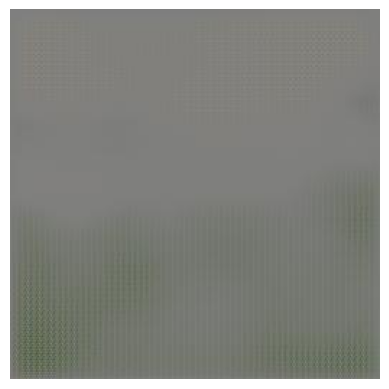

In [18]:
from PIL import Image
from zipfile import ZipFile
import os
import matplotlib.image as mpimg

outputR='/kaggle/working/generated/'
os.makedirs(outputR, exist_ok=True)

submission=batchSize
fakes=gen(tf.random.normal([submission,latentDim]))
i=1
print(fakes.shape)
for f in fakes:
    img = Image.fromarray(np.clip(f * 255, 0, 255).astype(np.uint8))
    img.save(outputR+str(i)+'.jpg')
    import matplotlib.image as mpimg

    if i==1:
        image =mpimg.imread(outputR+str(i)+'.jpg')
        plt.imshow(image)
        plt.axis('off') 
        plt.show()
    i+=1
    
with ZipFile('images.zip', 'w') as z:
    for f in os.listdir(outputR):
        z.write(outputR+f, arcname=f)

The sample is indeed a very beautiful and inspiring picture! I can almost see the horses running on the grass under the scalding sun and flowers blossoming in various colours in this AI-generated image.

As a conclusion, we have obtained a model that is capable of generating images of Monet that can deceive the discriminator. We can improve the performance of our model by continuing feeding pictures to it and increasing the number of iterations. 

MiFid was used to evaluate the generator; since as iterations go, MiFid decreases drastically, we can say that the generator has greatly improved its performance, which is confirmed by the sample image generated by the generator. However, we can still improve the generator by running more iterations and doing some hypertuning, which might take months' work, and this will be our future steps.

Last but not least, since we did not use the "photos", in our next step, we can feed those photos to both the discriminator and the generator, and maybe we will have some meaningful breakthroughs.